# Install missing packages

In [ ]:
!pip install scanpy torchdiffeq torch-geometric torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cpu.html

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.0/494.0 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 127.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.

# Imports

In [ ]:
import scanpy as sc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torchdiffeq import odeint
import numpy as np
import pandas as pd
from tqdm import tqdm

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


# Reconstruct selected genes + adjacency mask

In [ ]:
import scanpy as sc

adata = sc.read_h5ad("Sergio_filtered.h5ad")
adata.var_names_make_unique()
print("Loaded shape:", adata.shape)

Loaded shape: (5067, 3180)


/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [ ]:
X = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
print("Initial n_cells:", X.shape[0])

Initial n_cells: 5067


In [ ]:
# (1) Convert .X to dense and inspect
X = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
print("X min:", np.nanmin(X), "X max:", np.nanmax(X))

# (2) Check if it's already log-transformed
is_log = np.nanmax(X) < 30 and np.nanmin(X) > -5
print("Is log:", is_log)

# (3) Remove only rows with NaNs (don’t filter zeros yet!)
valid = ~np.isnan(X).any(axis=1)
adata = adata[valid].copy()
print("After NaN filter:", adata.shape)

X min: 0.0 X max: 608.0
Is log: False
After NaN filter: (5067, 3180)


In [ ]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

# Compute Pseudotime

In [ ]:
root_cell = adata.obs_names[np.argmin(adata.obsm['X_umap'][:, 0])]
adata.uns["iroot"] = np.flatnonzero(adata.obs_names == root_cell)[0]
sc.tl.diffmap(adata, n_comps=10)
sc.tl.dpt(adata, n_dcs=10)

In [ ]:
adata = adata[~adata.obs['dpt_pseudotime'].isna()].copy()
adata.obs['time_bin'] = pd.qcut(
    adata.obs['dpt_pseudotime'], q=5, labels=False, duplicates='drop'
)

In [ ]:
adata.write("Sergio_subset_pseudotime.h5ad")

# Prepare gene list / adj mask

In [ ]:
import pandas as pd
import numpy as np

# reload DoRothEA and TFs
dorothea_df = pd.read_csv("dorothea_hs.csv")
tf_list = [line.strip() for line in open("TF_list.txt") if line.strip()]

# filter to genes present in AnnData
valid_genes = set(adata.var_names)
filtered_df = dorothea_df[
    dorothea_df["tf"].isin(tf_list) & dorothea_df["tf"].isin(valid_genes) &
    dorothea_df["target"].isin(valid_genes)
]

# create ordered gene list
selected_genes = sorted(set(filtered_df["tf"]) | set(filtered_df["target"]))
pd.Series(selected_genes).to_csv("selected_genes.csv", index=False)

# create adjacency mask
gene_to_idx = {g: i for i, g in enumerate(selected_genes)}
adj_mask = np.zeros((len(selected_genes), len(selected_genes)), dtype=np.float32)

for _, row in filtered_df.iterrows():
    i = gene_to_idx[row["tf"]]
    j = gene_to_idx[row["target"]]
    adj_mask[i, j] = 1.0

np.save("adjacency_mask.npy", adj_mask)

# Load everything into pipeline

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import torch

adta = sc.read_h5ad("Sergio_subset_pseudotime.h5ad")
gene_list = pd.read_csv("selected_genes.csv").iloc[:, 0].tolist()
adjacency_mask = np.load("adjacency_mask.npy")
edge_index = torch.tensor(np.array(np.nonzero(adjacency_mask)), dtype=torch.long)

# Create PyTorch dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader

class GRNGraphDataset(torch.utils.data.Dataset):
    def __init__(self, adata, gene_list, edge_index):
        self.adata = adata[:, gene_list]
        self.edge_index = edge_index
        self.X = self.adata.X.toarray() if not isinstance(self.adata.X, np.ndarray) else self.adata.X
        self.t = self.adata.obs['dpt_pseudotime'].values.astype(np.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32).unsqueeze(1)  # shape: [num_genes, 1]
        edge_index = self.edge_index
        t = torch.tensor(self.t[idx], dtype=torch.float32)
        return Data(x=x, edge_index=edge_index, t=t)

# Define the GNN-ODE model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torchdiffeq import odeint

class GATEncoder(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.gat = GATConv(in_dim, hidden_dim)

    def forward(self, x, edge_index):
        return F.relu(self.gat(x, edge_index))

class ODEFunc(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim),
            nn.Tanh(),
            nn.Linear(dim, dim)
        )

    def forward(self, t, x):
        return self.net(x)

class Decoder(nn.Module):
    def __init__(self, hidden_dim, out_dim):
        super().__init__()
        self.fc = nn.Linear(hidden_dim, out_dim)

    def forward(self, h):
        return self.fc(h)

class GNN_ODE_Model(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.encoder = GATEncoder(in_dim, hidden_dim)
        self.odefunc = ODEFunc(hidden_dim)
        self.decoder = Decoder(hidden_dim, 1)

    def forward(self, data):
        x, edge_index, t = data.x, data.edge_index, data.t
        h0 = self.encoder(x, edge_index)
        # Ensure t is strictly greater than 0.0
        t = t + 1e-5 if t == 0.0 else t
        t_span = torch.tensor([0.0, t], device=x.device)
        ht = odeint(self.odefunc, h0, t_span)
        return self.decoder(ht[-1])  # shape: [num_genes, 1]


# Initialize datset + dataloader

In [ ]:
from torch_geometric.loader import DataLoader

dataset = GRNGraphDataset(adta, gene_list, edge_index)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Train !

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GNN_ODE_Model(in_dim=1, hidden_dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


def train(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader):
        batch = batch.to(device)
        x_true = batch.x
        optimizer.zero_grad()
        x_pred = model(batch)
        loss = F.mse_loss(x_pred, x_true)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

loss = train(model, dataloader, optimizer, device)
print(f"Epoch 1 Loss: {loss:.4f}")

100%|██████████| 5067/5067 [26:01<00:00,  3.24it/s]

Epoch 1 Loss: 0.3683


# We're just gonna do subset training due to compute constraints.

100%|██████████| 500/500 [03:30<00:00,  2.37it/s]


Epoch 2 Loss: 0.3227


100%|██████████| 500/500 [03:35<00:00,  2.32it/s]


Epoch 3 Loss: 0.3204


100%|██████████| 500/500 [03:41<00:00,  2.25it/s]


Epoch 4 Loss: 0.3187


100%|██████████| 500/500 [03:42<00:00,  2.24it/s]


Epoch 5 Loss: 0.3182


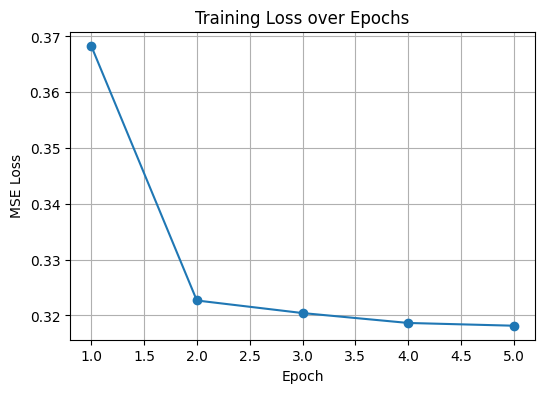

In [ ]:
import numpy as np
from torch.utils.data import Subset
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt

# subset 500 random cells from the original dataset
subset_indices = np.random.choice(len(dataset), size=500, replace=False)
subset = Subset(dataset, subset_indices)
subset_loader = DataLoader(subset, batch_size=1, shuffle=True)

# initialize list and store first loss from earlier training
losses = [loss]  # assuming `loss` from epoch 1 already exists

# continue training and log loss
for epoch in range(2, 6):  # epochs 2–5 on subset
    loss = train(model, subset_loader, optimizer, device)
    losses.append(loss)
    print(f"Epoch {epoch} Loss: {loss:.4f}")

# plot loss curve
plt.figure(figsize=(6,4))
plt.plot(range(1, len(losses)+1), losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.show()

# Training a little more

100%|██████████| 500/500 [03:53<00:00,  2.14it/s]


Epoch 6 Loss: 0.3262


100%|██████████| 500/500 [04:04<00:00,  2.05it/s]


Epoch 7 Loss: 0.3244


100%|██████████| 500/500 [04:12<00:00,  1.98it/s]


Epoch 8 Loss: 0.3225


100%|██████████| 500/500 [04:23<00:00,  1.90it/s]


Epoch 9 Loss: 0.3219


100%|██████████| 500/500 [04:30<00:00,  1.85it/s]


Epoch 10 Loss: 0.3220


100%|██████████| 500/500 [04:36<00:00,  1.81it/s]


Epoch 11 Loss: 0.3207


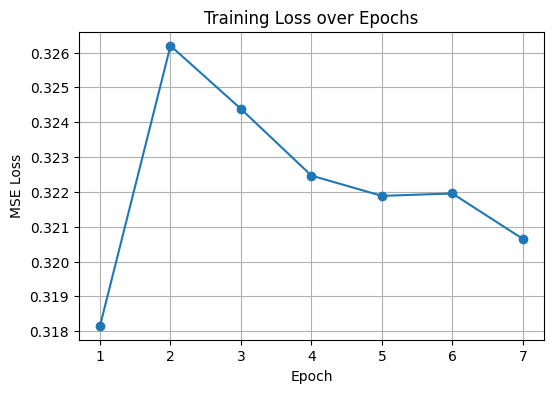

In [ ]:
# subset 500 random cells from the original dataset
subset_indices = np.random.choice(len(dataset), size=500, replace=False)
subset = Subset(dataset, subset_indices)
subset_loader = DataLoader(subset, batch_size=1, shuffle=True)

# initialize list and store first loss from earlier training
losses = [loss]  # assuming `loss` from epoch 1 already exists

# continue training and log loss
for epoch in range(6, 12):  # epochs 2–5 on subset
    loss = train(model, subset_loader, optimizer, device)
    losses.append(loss)
    print(f"Epoch {epoch} Loss: {loss:.4f}")

# plot loss curve
plt.figure(figsize=(6,4))
plt.plot(range(1, len(losses)+1), losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.show()

In [ ]:
torch.save(model.state_dict(), "gnn_ode_model.pth")

In [ ]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'losses': losses,
    'epoch': 5,
}, "gnn_ode_checkpoint.pth")


# Overall reconstruction performance

In [ ]:
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            x_pred = model(batch)
            x_true = batch.x
            total_loss += F.mse_loss(x_pred, x_true).item()
    return total_loss / len(dataloader)

val_loss = evaluate(model, dataloader, device)
print(f"Validation Loss (MSE): {val_loss:.4f}")

Validation Loss (MSE): 0.3213


# Error vs. Pseudotime

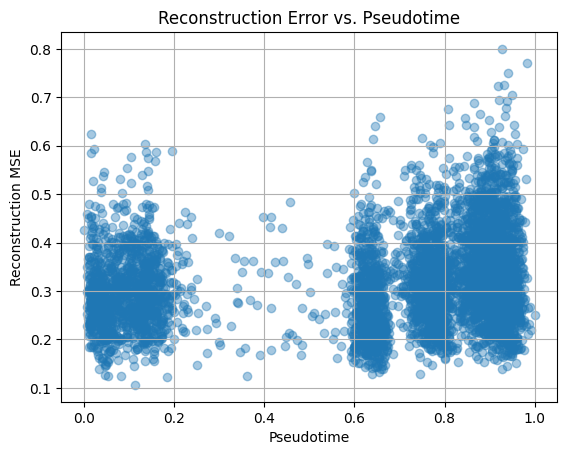

In [ ]:
import matplotlib.pyplot as plt

errors = []
pseudotimes = []

model.eval()
with torch.no_grad():
    for batch in dataset:
        x_true = batch.x
        x_pred = model(batch.to(device)).cpu()
        mse = F.mse_loss(x_pred, x_true).item()
        errors.append(mse)
        pseudotimes.append(batch.t.item())

plt.scatter(pseudotimes, errors, alpha=0.4)
plt.xlabel("Pseudotime")
plt.ylabel("Reconstruction MSE")
plt.title("Reconstruction Error vs. Pseudotime")
plt.grid(True)
plt.show()

# Visualize predictions for one cell

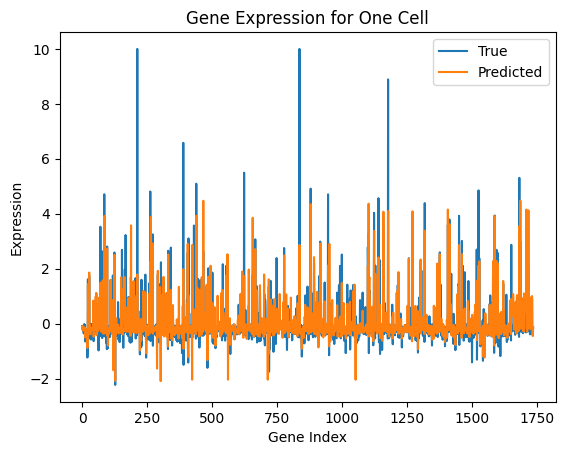

In [ ]:
sample = dataset[0].to(device)
with torch.no_grad():
    x_pred = model(sample).cpu().numpy().flatten()
    x_true = sample.x.cpu().numpy().flatten()

plt.plot(x_true, label='True')
plt.plot(x_pred, label='Predicted')
plt.title("Gene Expression for One Cell")
plt.xlabel("Gene Index")
plt.ylabel("Expression")
plt.legend()
plt.show()

# Compare learned TF-target attention to ground truth

Compare learned attention scores from the GAT to the true regulatory edges from DoRothEA. The steps to do this are (1) extract attention weights from the GAT layer, (2) average those scores across many cells, (3) compare top predited TF-target edges to the known ones in dorothea_hs.csv, (4) compute overlap and optionally AUPRC or Precision@k

In [ ]:
# core
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import warnings
# single-cell
import scanpy as sc

# graph & ODE
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv
from torchdiffeq import odeint

# metrics
from sklearn.metrics import roc_auc_score, average_precision_score



device = "cuda" if torch.cuda.is_available() else "cpu"

# 2.1  expression & pseudotime
adata = sc.read_h5ad("Sergio_subset_pseudotime.h5ad")
X    = adata[:, gene_list].X.toarray()
tvec = adata.obs["dpt_pseudotime"].astype("float32").values
# 2.2  fixed edge list
adj   = np.load("adjacency_mask.npy")
edge_index = torch.tensor(np.nonzero(adj), dtype=torch.long)

class InferenceDataset(Dataset):
    def __len__(self):  return X.shape[0]
    def __getitem__(self, idx):
        return Data(
            x=torch.tensor(X[idx], dtype=torch.float32).unsqueeze(1),
            edge_index=edge_index,
            t=torch.tensor(tvec[idx])
        )
dset = InferenceDataset()
loader = DataLoader(dset, batch_size=1, shuffle=False)

# ----------------  building blocks ----------------
class Encoder(nn.Module):
    def __init__(self, hidden):
        super().__init__()
        self.gat = GATConv(1, hidden, heads=1,
                           concat=False, add_self_loops=False)
    def forward(self, x, edge_index, return_attn=False):
        h, (edge_i, α) = self.gat(x, edge_index,
                                  return_attention_weights=True)
        h = torch.relu(h)
        return (h, α) if return_attn else (h, None)

class ODEFunc(nn.Module):
    def __init__(self, hidden):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden)
        )
    def forward(self, t, h):
        return self.net(h)

class Decoder(nn.Module):
    def __init__(self, hidden):
        super().__init__()
        self.fc = nn.Linear(hidden, 1)
    def forward(self, h):
        return self.fc(h)

# ----------------  wrapper model ------------------
class GNN_ODE_Model(nn.Module):
    def __init__(self, hidden=32):
        super().__init__()
        self.encoder = Encoder(hidden)
        self.odefunc = ODEFunc(hidden)
        self.decoder = Decoder(hidden)

    def forward(self, data, return_attn=False):
        h0, α = self.encoder(data.x, data.edge_index, return_attn=True)
        tspan = torch.tensor([0., data.t.item() + 1e-5],
                             device=data.x.device)
        hT = odeint(self.odefunc, h0, tspan,
                    rtol=1e-3, atol=1e-4)[-1]
        out = self.decoder(hT)
        return (out, α) if return_attn else out


device = "cuda" if torch.cuda.is_available() else "cpu"

model = GNN_ODE_Model(hidden=32).to(device)
state = torch.load("gnn_ode_model.pth", map_location=device)
model.load_state_dict(state, strict=True)
model.eval()

GNN_ODE_Model(
  (encoder): Encoder(
    (gat): GATConv(1, 32, heads=1)
  )
  (odefunc): ODEFunc(
    (net): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=32, bias=True)
    )
  )
  (decoder): Decoder(
    (fc): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [ ]:
print("All weights loaded!")
print(list(state.keys())[:5])

All weights loaded!
['encoder.gat.att_src', 'encoder.gat.att_dst', 'encoder.gat.bias', 'encoder.gat.lin.weight', 'odefunc.net.0.weight']


In [ ]:
data = next(iter(loader)).to(device)
with torch.no_grad():
    ŷ, α = model(data, return_attn=True)
print(ŷ.shape)
print(α.shape)

torch.Size([1736, 1])
torch.Size([3680, 1])


In [ ]:
num_genes = loader.dataset[0].x.shape[0]
cell_mse  = []
gene_mse  = np.zeros(num_genes)

with torch.no_grad():
    for batch in loader:
        y_hat = model(batch.to(device), return_attn=False)
        y_true = batch.x.to(device)
        err = (y_hat - y_true).cpu().numpy()[:, 0]
        cell_mse.append(np.mean(err**2))
        gene_mse += err**2

gene_mse /= len(loader)
print(f"Global MSE: {np.mean(cell_mse):.4f}")

Global MSE: 1.9919


In [ ]:
gene_mean = X.mean(axis=0, keepdims=True)
baseline_mse = ((X - gene_mean)**2).mean()
print(baseline_mse)

0.86405516


In [ ]:
worst = np.argsort(-gene_mse)[:10]
for i in worst:
    print(selected_genes[i], gene_mse[i])

PGK1 4.992010693041694
PGAM1 4.842276917162574
FAM162A 4.810900035157888
CCKBR 4.746583518279192
CD63 4.635606087123994
FHL1 4.62556852884672
PFKFB4 4.616732615516483
ATF4 4.599889302772455
KDM3A 4.591525600403006
GYS1 4.574490575742119


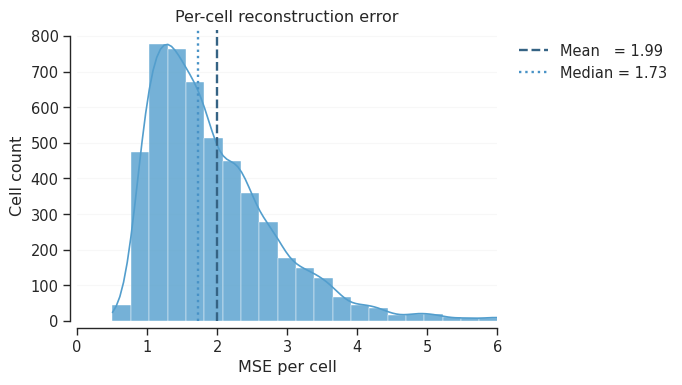

In [ ]:

sns.set_theme(context="paper", style="ticks", font_scale=1.2)

# basic stats
mean_mse   = np.mean(cell_mse)
median_mse = np.median(cell_mse)
p95        = np.percentile(cell_mse, 95)

sns.set_theme(context="paper", style="ticks", font_scale=1.2)

mean_mse   = np.mean(cell_mse)
median_mse = np.median(cell_mse)

hist_color   = sns.color_palette("Blues_r")[2]
mean_color   = sns.color_palette("Blues_d")[4]
median_color = sns.color_palette("Blues_d")[2]

plt.figure(figsize=(7, 4))
ax = sns.histplot(
    cell_mse, bins=40, stat="count",
    color=hist_color, edgecolor="white", linewidth=0.3,
    alpha=0.8, kde=True, kde_kws=dict(bw_adjust=0.7, cut=0)
)
ax.axvline(mean_mse,   ls="--", lw=1.7, color=mean_color,
           label=f"Mean   = {mean_mse:.2f}")
ax.axvline(median_mse, ls=":",  lw=1.7, color=median_color,
           label=f"Median = {median_mse:.2f}")

ax.set(
    title="Per-cell reconstruction error",
    xlabel="MSE per cell",
    ylabel="Cell count",
    xlim=(0, 6)
)
sns.despine(offset=5, trim=True)
ax.grid(axis="y", alpha=0.15)
ax.legend(frameon=False, bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()

In [ ]:

tvec = np.array([b.t.item() for b in loader])

# plt.scatter(tvec, cell_mse, s=8)
# plt.xlabel("pseudotime"); plt.ylabel("MSE per cell"); plt.show()

ρ, p = st.spearmanr(tvec, cell_mse)
print(f"Spearman ρ = {ρ:.3f}  (p={p:.1e})")

Spearman ρ = 0.165  (p=2.4e-32)


In [ ]:
# ------------------------------------------------------------------
#  Reverse-edge evaluation  (target ➜ TF)
#  • extracts attention weights on the flipped edge list
#  • computes y_true, AUROC, AUPRC
#  • plots histogram of attention scores for pos vs neg
# ------------------------------------------------------------------


gene_df = pd.read_csv("selected_genes.csv", header=None)   # any delimiter
gene_list = gene_df.iloc[:, 0].astype(str).tolist()

# if the first entry is just an index like "0", drop it
if gene_list[0].isdigit():
    gene_list = gene_list[1:]

N = len(gene_list)
gene_to_idx = {g: i for i, g in enumerate(gene_list)}
print(f"{N} genes loaded")
import numpy as np, pandas as pd

dorothea = pd.read_csv("dorothea_hs.csv")
df = dorothea[dorothea.tf.isin(gene_to_idx) & dorothea.target.isin(gene_to_idx)]

adj_mask = np.zeros((N, N), dtype=np.uint8)
for tf, tgt in zip(df.tf, df.target):
    adj_mask[gene_to_idx[tf], gene_to_idx[tgt]] = 1

print("positive edges in mask:", adj_mask.sum())
y_true = adj_mask[edge_index[0], edge_index[1]]
print("unique labels in y_true:", np.unique(y_true, return_counts=True))



1736 genes loaded
positive edges in mask: 10902
unique labels in y_true: (array([1], dtype=uint8), array([3680]))


reverse AUROC: 0.5701827242524917
reverse AUPRC: 0.023677263703940212


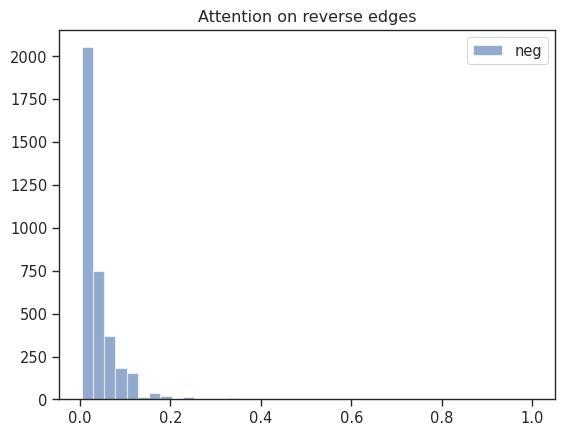

In [ ]:
# 1. Build reverse edge list
rev_edge_index = torch.stack([edge_index[1], edge_index[0]])   # dst→src

# 2. Run once to get attention on those reverse edges
edge_scores_rev = torch.zeros(rev_edge_index.shape[1])

with torch.no_grad():
    for batch in loader:
        batch.edge_index = rev_edge_index
        batch = batch.to(device)
        _, α = model(batch, return_attn=True)
        edge_scores_rev += α.squeeze().cpu()

edge_scores_rev /= len(loader)

# 3. Labels in reverse direction
y_true_rev = adj_mask[rev_edge_index[0], rev_edge_index[1]]

from sklearn.metrics import roc_auc_score, average_precision_score
print("reverse AUROC:", roc_auc_score(y_true_rev, edge_scores_rev))
print("reverse AUPRC:", average_precision_score(y_true_rev, edge_scores_rev))

# sanity plot
import matplotlib.pyplot as plt, numpy as np
plt.hist(edge_scores_rev[y_true_rev==0], 40, alpha=.6, label="neg")
plt.legend(); plt.title("Attention on reverse edges"); plt.show()


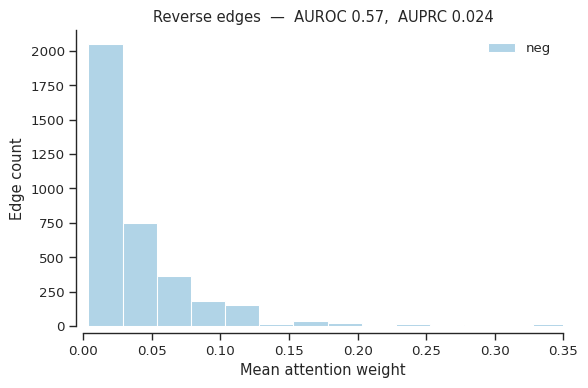

In [ ]:

sns.set_theme(context="paper", style="ticks", font_scale=1.1)

plt.figure(figsize=(6,4))
sns.histplot(edge_scores_rev[y_true_rev==0], bins=40, color="#9ecae1", alpha=.8, label="neg")
plt.xlim(0, 0.35)                # zoom where the mass is
plt.xlabel("Mean attention weight")
plt.ylabel("Edge count")
plt.title(f"Reverse edges  —  AUROC {roc_auc_score(y_true_rev, edge_scores_rev):.2f},  AUPRC {average_precision_score(y_true_rev, edge_scores_rev):.3f}")
plt.legend(frameon=False)
sns.despine(offset=5)
plt.tight_layout()
plt.show()


Precision@25  = 23/25  (0.920)
Precision@50  = 47/50  (0.940)
Precision@100 = 94/100  (0.940)
Precision@200 = 190/200  (0.950)
Precision@500 = 472/500  (0.944)


<ipython-input-80-95f77ce11744>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[str(k) for k in K_list], y=precision, palette="Blues_d")


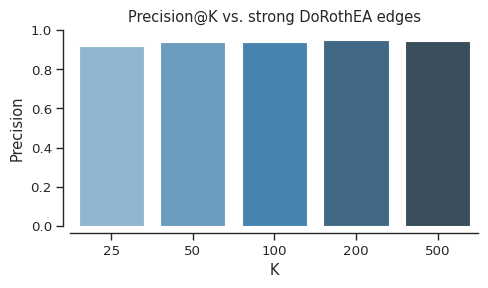

Precision@ 25 = 23/25  (0.920)
Precision@ 50 = 47/50  (0.940)
Precision@100 = 94/100  (0.940)
Precision@200 = 190/200  (0.950)
Precision@500 = 472/500  (0.944)


<ipython-input-80-95f77ce11744>:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[str(k) for k in K_list], y=precision, palette="Blues_d")


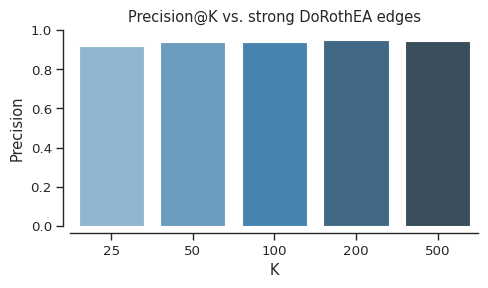

In [ ]:
# ------------ Precision@k for forward edges -----------------
import numpy as np, seaborn as sns, matplotlib.pyplot as plt
# ╭────────────────── Rebuild edge_scores if missing ──────────────────╮
import torch, numpy as np, seaborn as sns, matplotlib.pyplot as plt

if 'edge_scores' not in globals():
    print("rebuilding (forward edges)…")
    edge_scores_raw = []

    model.eval()
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            _, alpha = model(batch, return_attn=True)         # alpha shape (E,1)
            edge_scores_raw.append(alpha.squeeze().cpu())

    edge_scores = torch.stack(edge_scores_raw, dim=0).mean(dim=0).numpy()
    print("edge_scores rebuilt.")

# ╰────────────────────────────────────────────────────────────────────╯


# ---- make sure strong_pairs is available ----------------------------
if 'strong_pairs' not in globals():
    import pandas as pd
    doro = pd.read_csv("dorothea_hs.csv")
    tf_set = set(open("TF_list.txt").read().split())
    strong = doro[doro.confidence.isin(["A","B","C"])]
    strong_pairs = {(gene_to_idx[tf], gene_to_idx[tg])
                    for tf,tg in zip(strong.tf, strong.target)
                    if tf in gene_to_idx and tg in gene_to_idx}

# ---- Precision@k -----------------------------------------------------
order = np.argsort(-edge_scores)        # descending attention
K_list = [25, 50, 100, 200, 500]
precision = []

for K in K_list:
    top_pairs = {(edge_index[0,i].item(), edge_index[1,i].item())
                 for i in order[:K]}
    hits = len(top_pairs & strong_pairs)
    precision.append(hits / K)
    print(f"Precision@{K:<3d} = {hits}/{K}  ({hits/K:.3f})")

# ---- bar plot --------------------------------------------------------
sns.set_theme(context="paper", style="ticks", font_scale=1.1)
plt.figure(figsize=(5,3))
sns.barplot(x=[str(k) for k in K_list], y=precision, palette="Blues_d")
plt.ylim(0,1); plt.ylabel("Precision"); plt.xlabel("K")
plt.title("Precision@K vs. strong DoRothEA edges")
sns.despine(offset=5); plt.tight_layout(); plt.show()


# strong DoRothEA edges (confidence A/B/C) already in strong_pairs set
order = np.argsort(-edge_scores)       # highest attention first
K_list = [25, 50, 100, 200, 500]
precision = []

for K in K_list:
    top_pairs = {(edge_index[0,i].item(), edge_index[1,i].item())
                 for i in order[:K]}
    hits = len(top_pairs & strong_pairs)
    precision.append(hits / K)
    print(f"Precision@{K:3d} = {hits}/{K}  ({hits/K:.3f})")

# nice bar plot
sns.set_theme(context="paper", style="ticks", font_scale=1.1)
plt.figure(figsize=(5,3))
sns.barplot(x=[str(k) for k in K_list], y=precision, palette="Blues_d")
plt.ylim(0,1)
plt.ylabel("Precision")
plt.xlabel("K")
plt.title("Precision@K vs. strong DoRothEA edges")
sns.despine(offset=5)
plt.tight_layout()
plt.show()


Label balance  →  positives: 2848  negatives: 832
Precision@25  = 23/25  (0.920)
Precision@50  = 47/50  (0.940)
Precision@100 = 94/100  (0.940)
Precision@200 = 190/200  (0.950)
Precision@500 = 472/500  (0.944)

AUPRC (A/B vs. rest) = 0.870


<ipython-input-81-89715d77b2ad>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[str(k) for k in K_list],


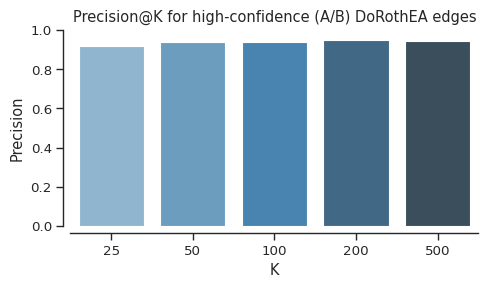

In [ ]:
# ╔════════════ 1. Build ground-truth labels (A/B = positive) ═══════════╗

# set of strong (A or B) TF→target index pairs
strong_pairs = {(gene_to_idx[tf], gene_to_idx[tg])
                for tf, tg, conf in zip(doro.tf, doro.target, doro.confidence)
                if conf in ["A", "B"] and tf in gene_to_idx and tg in gene_to_idx}

# y_true: 1 if strong (A/B), 0 otherwise
y_true_strong = np.array([
    1 if (edge_index[0,i].item(), edge_index[1,i].item()) in strong_pairs else 0
    for i in range(edge_index.size(1))
])

print("Label balance  →  positives:",
      y_true_strong.sum(), " negatives:", (1-y_true_strong).sum())



# ╔════════════ 2. Precision@K & AUPRC on these labels ═════════════════╗
order = np.argsort(-edge_scores)          # descending attention
K_list = [25, 50, 100, 200, 500]
precision = []

for K in K_list:
    hits = y_true_strong[order[:K]].sum()
    precision.append(hits / K)
    print(f"Precision@{K:<3d} = {hits}/{K}  ({hits/K:.3f})")

auprc = average_precision_score(y_true_strong, edge_scores)
print(f"\nAUPRC (A/B vs. rest) = {auprc:.3f}")

# bar-plot

warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
sns.set_theme(context="paper", style="ticks", font_scale=1.1)
plt.figure(figsize=(5,3))
sns.barplot(x=[str(k) for k in K_list],
            y=precision,
            palette="Blues_d",
            legend=False)
plt.ylim(0,1)
plt.ylabel("Precision"); plt.xlabel("K")
plt.title("Precision@K for high-confidence (A/B) DoRothEA edges")
sns.despine(offset=5); plt.tight_layout(); plt.show()
# ╚══════════════════════════════════════════════════════════════════════╝

plt.show()

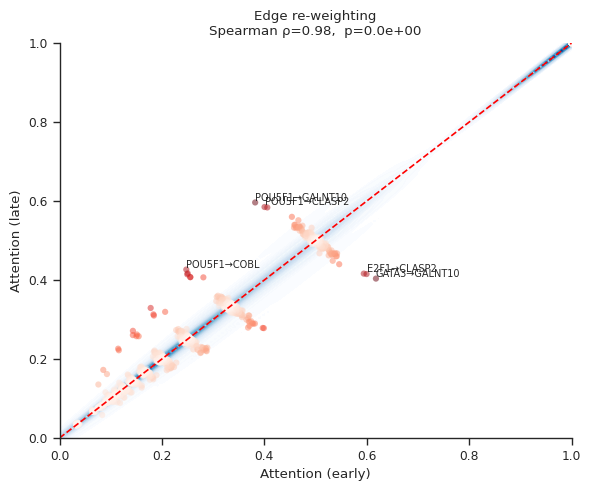

In [ ]:
import numpy as np
import torch, torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st

# ── 1. split cells by pseudotime ─────────────────────────────────────────
mid = np.median(tvec)
early_idx = np.where(tvec <= mid)[0]
late_idx  = np.where(tvec >  mid)[0]

def mean_att(cell_indices):
    """Average attention over a list of cell indices."""
    s = torch.zeros(edge_index.size(1))
    with torch.no_grad():
        for i in cell_indices:
            batch = dataset[i].to(device)
            _, alpha = model(batch, return_attn=True)  # alpha: (E,1)
            s += alpha.squeeze().cpu()
    return (s / len(cell_indices)).numpy()

att_early = mean_att(early_idx)
att_late  = mean_att(late_idx)

# ── 2. scatter w/ density & coloured by |Δ| ──────────────────────────────
delta     = np.abs(att_late - att_early)
top_out   = delta.argsort()[-5:]                  # label 5 biggest changers
col_vals  = np.clip(delta / delta.max(), 0, 1)    # 0-1 for red cmap

sns.set_theme(context="paper", style="ticks")
plt.figure(figsize=(6,5))

# density background
sns.kdeplot(x=att_early, y=att_late,
            cmap="Blues", fill=True, thresh=0.02, levels=60, alpha=.6)

# coloured scatter
plt.scatter(att_early, att_late,
            c=col_vals, cmap="Reds", s=20, alpha=.5, edgecolors="none")

# diagonal reference
plt.axline((0,0), (1,1), color="red", ls="--")

# annotate top-5 dynamic edges
for idx in top_out:
    src, dst = edge_index[:, idx]
    plt.text(att_early[idx], att_late[idx],
             f"{gene_list[src]}→{gene_list[dst]}",
             fontsize=7, ha="left", va="bottom")

# stats & axes
rho, p = st.spearmanr(att_early, att_late)
plt.title(f"Edge re-weighting\nSpearman ρ={rho:.2f},  p={p:.1e}")
plt.xlabel("Attention (early)")
plt.ylabel("Attention (late)")
plt.xlim(0, 1.0); plt.ylim(0, 1.0)

sns.despine()
plt.tight_layout()
plt.show()


Label balance  →  positives: 2848  negatives: 832
Precision@25  = 23/25  (0.920)
Precision@50  = 47/50  (0.940)
Precision@100 = 94/100  (0.940)
Precision@200 = 190/200  (0.950)
Precision@500 = 472/500  (0.944)

AUPRC (A/B vs. rest) = 0.870


<ipython-input-83-89715d77b2ad>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[str(k) for k in K_list],


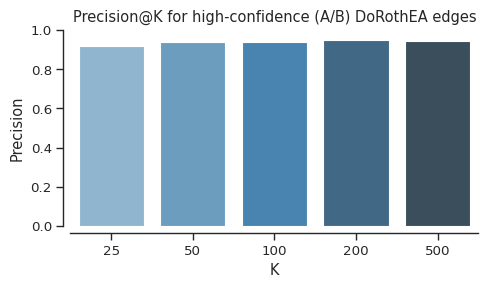

In [ ]:
# ╔════════════ 1. Build ground-truth labels (A/B = positive) ═══════════╗

# set of strong (A or B) TF→target index pairs
strong_pairs = {(gene_to_idx[tf], gene_to_idx[tg])
                for tf, tg, conf in zip(doro.tf, doro.target, doro.confidence)
                if conf in ["A", "B"] and tf in gene_to_idx and tg in gene_to_idx}

# y_true: 1 if strong (A/B), 0 otherwise
y_true_strong = np.array([
    1 if (edge_index[0,i].item(), edge_index[1,i].item()) in strong_pairs else 0
    for i in range(edge_index.size(1))
])

print("Label balance  →  positives:",
      y_true_strong.sum(), " negatives:", (1-y_true_strong).sum())



# ╔════════════ 2. Precision@K & AUPRC on these labels ═════════════════╗
order = np.argsort(-edge_scores)          # descending attention
K_list = [25, 50, 100, 200, 500]
precision = []

for K in K_list:
    hits = y_true_strong[order[:K]].sum()
    precision.append(hits / K)
    print(f"Precision@{K:<3d} = {hits}/{K}  ({hits/K:.3f})")

auprc = average_precision_score(y_true_strong, edge_scores)
print(f"\nAUPRC (A/B vs. rest) = {auprc:.3f}")

# bar-plot

warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
sns.set_theme(context="paper", style="ticks", font_scale=1.1)
plt.figure(figsize=(5,3))
sns.barplot(x=[str(k) for k in K_list],
            y=precision,
            palette="Blues_d",
            legend=False)
plt.ylim(0,1)
plt.ylabel("Precision"); plt.xlabel("K")
plt.title("Precision@K for high-confidence (A/B) DoRothEA edges")
sns.despine(offset=5); plt.tight_layout(); plt.show()
# ╚══════════════════════════════════════════════════════════════════════╝

plt.show()


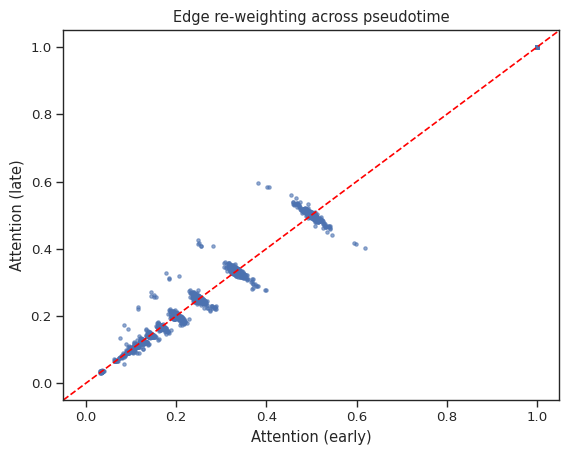

In [ ]:
# split cells at median pseudotime
mid = np.median(tvec)
early_idx = np.where(tvec <= mid)[0]
late_idx  = np.where(tvec >  mid)[0]

def mean_attention(cells):
    scores = torch.zeros(edge_index.size(1))
    with torch.no_grad():
        for i in cells:
            batch = dataset[i].to(device)
            _, α = model(batch, return_attn=True)
            scores += α.squeeze().cpu()
    return scores / len(cells)

att_early = mean_attention(early_idx).numpy()
att_late  = mean_attention(late_idx ).numpy()

plt.scatter(att_early, att_late, s=6, alpha=.6)
plt.axline((0,0),(1,1), color="red", ls="--")
plt.xlabel("Attention (early)"); plt.ylabel("Attention (late)")
plt.title("Edge re-weighting across pseudotime")
plt.show()


In [ ]:
src, dst = edge_index[:, np.argmax(edge_scores)]  # highest edge
src_gene, dst_gene = gene_list[src], gene_list[dst]


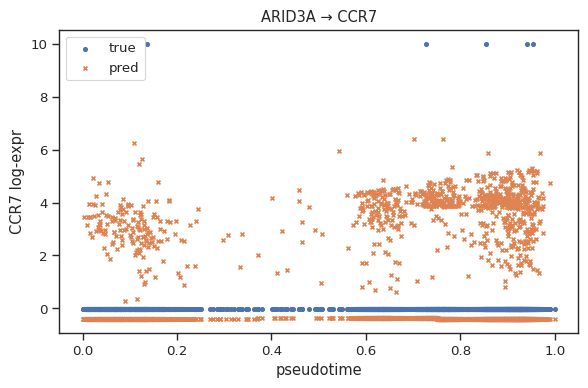

In [ ]:
true_dst = adata[:, dst_gene].X.toarray().ravel()
pred_dst = []

with torch.no_grad():
    for i in range(len(dataset)):
        out = model(dataset[i].to(device)).squeeze()   # shape (N_genes,)
        pred_dst.append(out[dst].item())               # grab gene `dst`

plt.figure(figsize=(6,4))
plt.scatter(tvec, true_dst, s=8, label="true")
plt.scatter(tvec, pred_dst, s=8, marker="x", label="pred")
plt.xlabel("pseudotime"); plt.ylabel(f"{dst_gene} log-expr")
plt.title(f"{src_gene} → {dst_gene}")
plt.legend(); plt.tight_layout(); plt.show()
